In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!pip install Adam

In [ ]:
!pip install keras
!pip install gensim

In [ ]:
!pip install tensorflow
!pip install word2vec

In [ ]:
import dill
import keras.backend as K
import multiprocessing
import tensorflow as tf

from gensim.models.word2vec import Word2Vec

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D
from tensorflow.keras.optimizers import Adam
import numpy as np

from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import RegexpTokenizer

In [ ]:
# Set random seed (for reproducibility)
np.random.seed(1000)

In [ ]:
# Select whether using Keras with or without GPU support
# See: https://stackoverflow.com/questions/40690598/can-keras-with-tensorflow-backend-be-forced-to-use-cpu-or-gpu-at-will
from tensorflow.python.keras import backend as K
use_gpu = True

config =tf.compat.v1.ConfigProto(intra_op_parallelism_threads=multiprocessing.cpu_count(),   #replace: tf.ConfigProto by tf.compat.v1.ConfigProto
                        inter_op_parallelism_threads=multiprocessing.cpu_count(), 
                        allow_soft_placement=True, 
                        device_count = {'CPU' : 1, 
                                        'GPU' : 1 if use_gpu else 0})

session = tf.compat.v1.Session(config=config)
K.set_session(session)


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/foo.txt'

Hello Google Drive!

In [ ]:
dataset_location = '/gdrive/MyDrive/sentimentAnalysis/dataset.csv'
model_location = '/gdrive/MyDrive/sentimentAnalysis/model/'

Parse tweet corpus and sentiments

In [ ]:
corpus = []
labels = []

In [ ]:
with open(dataset_location, 'r', encoding='utf-8') as df:
    for i, line in enumerate(df):
        if i == 0:
            # Skip the header
            continue

        parts = line.strip().split(',')
        
        # Sentiment (0 = Negative, 1 = Positive)
        labels.append(int(parts[1].strip()))
        
        # Tweet
        tweet = parts[3].strip()
        if tweet.startswith('"'):
            tweet = tweet[1:]
        if tweet.endswith('"'):
            tweet = tweet[::-1]
        
        corpus.append(tweet.strip().lower())
        
print('Corpus size: {}'.format(len(corpus)))

Corpus size: 1578627


Tokenize and remove stopwords

In [ ]:
tkr = RegexpTokenizer('[a-zA-Z0-9@]+')
stemmer = LancasterStemmer()

In [ ]:
tokenized_corpus = []

for i, tweet in enumerate(corpus):
    tokens = [stemmer.stem(t) for t in tkr.tokenize(tweet) if not t.startswith('@')]
    tokenized_corpus.append(tokens)

Save tokenized corpus

In [ ]:
with open(model_location + 'tokenized_corpus.dill', 'wb') as f:
    dill.dump(tokenized_corpus, f)

Load tokenized corpus

In [ ]:
with open(model_location + 'tokenized_corpus.dill', 'rb') as f:
    tokenized_corpus = dill.load(f)

Gensim Word2Vec model

In [ ]:
vector_size = 512
window_size = 10

In [ ]:
# Create Word2Vec
word2vec = Word2Vec(sentences=tokenized_corpus,
                    size=vector_size, 
                    window=window_size, 
                    negative=20,
                    iter=50,
                    seed=1000,
                    workers=multiprocessing.cpu_count())

Save Word2Vec model

In [ ]:
word2vec.save(model_location + 'word2vec.model')

Load Word2Vec model

In [ ]:
word2vec = Word2Vec.load(model_location + 'word2vec.model')

Copy word vectors and delete Word2Vec model and original corpus to save memory

In [ ]:
X_vecs = word2vec.wv

del word2vec
del corpus

Train subset size (0 < size < len(tokenized_corpus))

In [ ]:
train_size = 250000

Test subset size (0 < size < len(tokenized_corpus) - train_size)

In [ ]:
test_size = 80000

Compute average and max tweet length

In [ ]:
avg_length = 0.0
max_length = 0

for tweet in tokenized_corpus:
    if len(tweet) > max_length:
        max_length = len(tweet)
    avg_length += float(len(tweet))
    
print('Average tweet length: {}'.format(avg_length / float(len(tokenized_corpus))))
print('Max tweet length: {}'.format(max_length))

Average tweet length: 11.02887762593697
Max tweet length: 53


Tweet max length (number of tokens)

In [ ]:
max_tweet_length = 15

Create train and test sets

In [ ]:
# Generate random indexes
indexes = np.random.choice(len(tokenized_corpus), train_size + test_size, replace=False)

X_train = np.zeros((train_size, max_tweet_length, vector_size), dtype=K.floatx())
Y_train = np.zeros((train_size, 2), dtype=np.int32)
X_test = np.zeros((test_size, max_tweet_length, vector_size), dtype=K.floatx())
Y_test = np.zeros((test_size, 2), dtype=np.int32)

for i, index in enumerate(indexes):
    for t, token in enumerate(tokenized_corpus[index]):
        if t >= max_tweet_length:
            break
        
        if token not in X_vecs:
            continue
    
        if i < train_size:
            # print(i)
            X_train[i, t, :] = X_vecs[token]
        else:
            X_test[i - train_size, t, :] = X_vecs[token]
            
    if i < train_size:
        Y_train[i, :] = [1.0, 0.0] if labels[index] == 0 else [0.0, 1.0]
    else:
        Y_test[i - train_size, :] = [1.0, 0.0] if labels[index] == 0 else [0.0, 1.0]

Keras Convolutional model

In [ ]:
batch_size = 32
nb_epochs = 100

In [ ]:
model = Sequential()

model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same', input_shape=(max_tweet_length, vector_size)))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Dropout(0.25))

model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Fit the model
history=model.fit(X_train, Y_train,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(X_test, Y_test),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)])

Epoch 1/100
7813/7813 [==============================] - 161s 20ms/step - loss: 0.5502 - accuracy: 0.7237 - val_loss: 0.5166 - val_accuracy: 0.7515
Epoch 2/100
7813/7813 [==============================] - 158s 20ms/step - loss: 0.5084 - accuracy: 0.7532 - val_loss: 0.5020 - val_accuracy: 0.7559
Epoch 3/100
7813/7813 [==============================] - 164s 21ms/step - loss: 0.4935 - accuracy: 0.7634 - val_loss: 0.4949 - val_accuracy: 0.7609
Epoch 4/100
7813/7813 [==============================] - 158s 20ms/step - loss: 0.4828 - accuracy: 0.7705 - val_loss: 0.4949 - val_accuracy: 0.7628
Epoch 5/100
7813/7813 [==============================] - 161s 21ms/step - loss: 0.4742 - accuracy: 0.7762 - val_loss: 0.5014 - val_accuracy: 0.7623


In [ ]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 76.23%


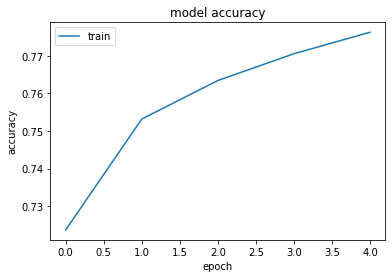

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

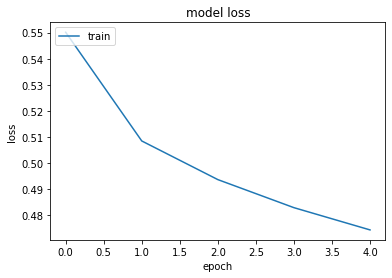

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

In [ ]:
def predict(text):
    # Tokenize text
    corpus = []
    tweet = text.strip()
    # print(tweet) 
    corpus.append(tweet.strip().lower())
    # print(corpus) 

    tokenized_corpus = []

    for i, tweet in enumerate(corpus):
        tokens = [stemmer.stem(t) for t in tkr.tokenize(tweet) if not t.startswith('@')]
        tokenized_corpus.append(tokens)

    tokenized_corpus = tokenized_corpus[0]
    # print(tokenized_corpus)

    #Word2vec

    test_a = np.zeros((1, max_tweet_length, vector_size), dtype=K.floatx())
    # print(test_a)

    for t, token in enumerate(tokenized_corpus):
            # print(tokenized_corpus[t])
            if t >= max_tweet_length:
                break
            # print(tokenized_corpus[t])
            if token not in X_vecs:
                continue
          
            test_a[0, t, :] = X_vecs[token]

    # Predict
    score = model.predict([test_a])
    input_list = list(score[0])
    max_value = max(input_list)
    index = input_list.index(max_value)

    # Sentiment (0 = Negative, 1 = Positive)
    if index == 0 :
      sentiment = "Negative"
    if index == 1 :
      sentiment = "Positive"
    

    return {"label" : index,
            "sentiment" : sentiment,
        "score": score}  

In [ ]:
predict(input("Enter your tweet: "))

.h5 file

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
import os
# os.mkdir("/gdrive/MyDrive/2Twitter-Sentiment-Analysis/save3")
os.chdir("/gdrive/MyDrive/2Twitter-Sentiment-Analysis/")
!ls

In [ ]:
#Append your path
import sys
sys.path.append('/gdrive/MyDrive/2Twitter-Sentiment-Analysis/save2')

In [ ]:
#Now save the model in required directory
import json
model.save('/gdrive/MyDrive/2Twitter-Sentiment-Analysis/save2/sentiment_analysis_model_large.h5')
# json_string = tkr.to_json()
print("Saved model to disk")

In [ ]:
#Check the content of the directory
os.chdir("/gdrive/MyDrive/2Twitter-Sentiment-Analysis/save2")
!ls

In [ ]:
#Code to load the saved model
from keras import models  
from keras.models import load_model
# model = model.load_model('/gdrive/MyDrive/2Twitter-Sentiment-Analysis/save2/sentiment_analysis_model_large.h5')
model = tf.keras.models.load_model('/gdrive/MyDrive/2Twitter-Sentiment-Analysis/save2/sentiment_analysis_model_large.h5')
print("Model Loaded")

Pickle file

In [ ]:
import pickle

In [ ]:
filename = '/gdrive/MyDrive/2Twitter-Sentiment-Analysis/save3/sentiment_model.sav'
pickle.dump(model ,open(filename,'wb'))

INFO:tensorflow:Assets written to: ram://ee3e476d-4ea6-4597-af5d-beff44139314/assets


In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))